# Kaggle RSNA Intracranial Hemorrhage Detection example

In [11]:
from functools import reduce
import os
import pickle
import random

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from features import CNNFeatureExtractor

In [2]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

In [3]:
RANDOM_SEED = 2020
DEBUG_MODE = True

DATA_BASE_PATH = '/data/'
PNG_DIR = 'png_256/'
NUM_SUBJ_PER_SPLIT = 50

IMG_DIR = DATA_BASE_PATH + PNG_DIR + "train"
SAVE_DIR = DATA_BASE_PATH + "png_256_resnet50features/" + str(NUM_SUBJ_PER_SPLIT) + "_subj_per_split/"

## Load the image feature datasets

In [4]:
with open(SAVE_DIR + "features_train.npy", "rb") as f:
    X_train = np.load(f)
    img_names_train = np.load(f)
    
with open(SAVE_DIR + "features_test.npy", "rb") as f:
    X_test = np.load(f)
    img_names_test = np.load(f)

with open(SAVE_DIR + "features_lockbox.npy", "rb") as f:
    X_lockbox = np.load(f)
    img_names_lockbox = np.load(f)

## Load the image labels

In [5]:
labels_df = pd.read_csv(DATA_BASE_PATH + PNG_DIR + 'pivot_df.csv')
del labels_df['Unnamed: 0']
labels_df = labels_df.set_index('filename')

In [6]:
labels_train_df = labels_df.loc[[os.path.basename(f) for f in img_names_train]]
labels_test_df = labels_df.loc[[os.path.basename(f) for f in img_names_test]]
labels_lockbox_df = labels_df.loc[[os.path.basename(f) for f in img_names_lockbox]]

labels_test_df

,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
filename,,,,,,
ID_4166af295.png,0,0,0,0,0,0
ID_f428bb3e7.png,0,0,0,0,0,0
ID_8513fb5cc.png,0,0,0,0,0,0
ID_3d2d45403.png,1,0,0,0,0,1
ID_f66deaba0.png,0,0,0,0,0,0
...,...,...,...,...,...,...
ID_d0a1e36c4.png,0,0,0,0,0,0
ID_791b3c7a8.png,0,0,0,0,0,0
ID_5b6ef0304.png,0,0,0,0,0,0


In [7]:
y_train = labels_train_df["any"].values
y_test = labels_test_df["any"].values
y_lockbox = labels_lockbox_df["any"].values
y_train

array([0, 0, 0, ..., 0, 0, 0])

Final data matrices and label vectors:

In [8]:
print(X_train.shape, X_test.shape, X_lockbox.shape,
      y_train.shape, y_test.shape, y_lockbox.shape)

(198543, 2048) (198381, 2048) (355878, 2048) (198543,) (198381,) (355878,)


## Fit a logistic regression classifier on the training data

Feature standardization prior to logistic regression

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_lockbox_scaled = scaler.transform(X_lockbox)

### First fit a model without regularization

In [38]:
logit_model = LogisticRegression(
    penalty="none", solver="lbfgs", random_state=RANDOM_SEED, max_iter=10000
)
logit_model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=2020, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

* Accuracy on the training data:

In [39]:
logit_model.score(X_train_scaled, y_train)

0.8786358622565389

* Accuracy on the test data:

In [40]:
logit_model.score(X_test_scaled, y_test)

0.8643368064481982

* Accuracy on the lockbox data:

In [41]:
logit_model.score(X_lockbox_scaled, y_lockbox)

0.8618318637285811

* AUC of training data:

In [44]:
y_train_pred = logit_model.predict_proba(X_train_scaled)
roc_auc_score(y_train, y_train_pred[:,1])

0.8541853840351695

* AUC on test data:

In [45]:
y_test_pred = logit_model.predict_proba(X_test_scaled)
roc_auc_score(y_test, y_test_pred[:,1])

0.8218309351702637

* AUC on lockbox data:

In [46]:
y_lockbox_pred = logit_model.predict_proba(X_lockbox_scaled)
roc_auc_score(y_lockbox, y_lockbox_pred[:,1])

0.8176589777160388

### Fit an (L1, L2)-regularized model with penalty parameter chosen via cross-validation

Choosing the regularization parameter for logistic regression

With feature standardization

**This takes multiple days to run:**

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

c_values = np.logspace(-3, 2, 10)
l1_ratios = np.linspace(0, 1, 5)

logit_searcher = LogisticRegressionCV(
    Cs=c_values, l1_ratios=l1_ratios, penalty="elasticnet", solver="saga",
    cv=skf, verbose=1, n_jobs=4, max_iter=10000, scoring="roc_auc", refit=True
)
logit_searcher.fit(X_train_scaled, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 804 epochs took 2225 seconds
convergence after 771 epochs took 2527 seconds
convergence after 694 epochs took 2594 seconds
convergence after 849 epochs took 2664 seconds
convergence after 834 epochs took 3110 seconds
convergence after 1405 epochs took 3885 seconds
convergence after 1375 epochs took 5718 seconds
convergence after 1585 epochs took 7153 seconds
convergence after 1985 epochs took 5484 seconds
convergence after 1825 epochs took 5042 seconds
convergence after 2941 epochs took 13178 seconds
convergence after 1075 epochs took 2970 seconds
convergence after 2664 epochs took 10403 seconds
convergence after 381 epochs took 1052 seconds
convergence after 118 epochs took 326 seconds
convergence after 34 epochs took 94 seconds
convergence after 10 epochs took 28 seconds
convergence after 2 epochs took 6 seconds
convergence after 2979 epochs took 12873 seconds
convergence after 809 epochs took 2443 seconds
convergence after 878 epochs took 2903 seconds
convergence a

convergence after 40 epochs took 134 seconds
convergence after 12 epochs took 39 seconds
convergence after 3 epochs took 10 seconds
convergence after 2674 epochs took 11590 seconds
convergence after 833 epochs took 2297 seconds
convergence after 1285 epochs took 5005 seconds
convergence after 537 epochs took 2018 seconds
convergence after 169 epochs took 606 seconds
convergence after 48 epochs took 164 seconds
convergence after 1383 epochs took 3814 seconds
convergence after 14 epochs took 46 seconds
convergence after 3 epochs took 9 seconds
convergence after 1456 epochs took 5883 seconds
convergence after 680 epochs took 2525 seconds
convergence after 626 epochs took 2380 seconds
convergence after 198 epochs took 714 seconds
convergence after 57 epochs took 195 seconds
convergence after 15 epochs took 49 seconds
convergence after 5 epochs took 16 seconds
convergence after 1728 epochs took 4768 seconds
convergence after 2793 epochs took 12355 seconds
convergence after 766 epochs took 2

[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 3793.0min finished


LogisticRegressionCV(Cs=array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=2020, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                     max_iter=10000, multi_class='warn', n_jobs=4,
                     penalty='elasticnet', random_state=None, refit=True,
                     scoring='roc_auc', solver='saga', tol=0.0001, verbose=1)

Save the model:

In [12]:
# save the model to disk
pickle.dump(logit_searcher, open('elastic_net.sav', 'wb'))

Load the model from disk:

In [13]:
# load the model from disk
elastic_net = pickle.load(open('elastic_net.sav', 'rb'))

In [28]:
logit_searcher.scores_[1].shape

(5, 10, 5)

Text(0, 0.5, 'Mean CV-accuracy')

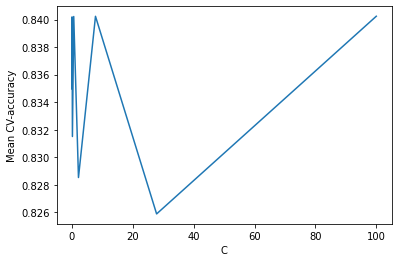

In [26]:
plt.plot(c_values, np.mean(elastic_net.scores_[1], axis=(0, 2)))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy')

Text(0, 0.5, 'Mean CV-accuracy')

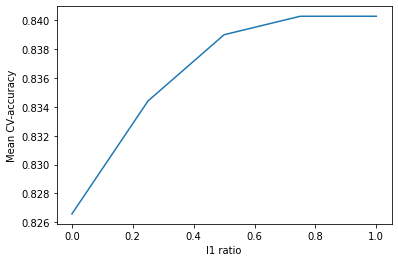

In [29]:
plt.plot(l1_ratios, np.mean(elastic_net.scores_[1], axis=(0, 1)))
plt.xlabel('l1 ratio')
plt.ylabel('Mean CV-accuracy')

In [37]:
optim_c = elastic_net.C_[0]
optim_l1 = elastic_net.l1_ratio_[0]

print(optim_c, optim_l1)

0.046415888336127795 0.5


* AUC of training data:

In [46]:
y_train_pred = elastic_net.predict_proba(X_train_scaled)
roc_auc_score(y_train, y_train_pred[:,1])

0.8532523657343789

* AUC on test data:

In [47]:
y_test_pred = elastic_net.predict_proba(X_test_scaled)
roc_auc_score(y_test, y_test_pred[:,1])

0.8239129163928107

* AUC on lockbox data:

In [48]:
y_lockbox_pred = elastic_net.predict_proba(X_lockbox_scaled)
roc_auc_score(y_lockbox, y_lockbox_pred[:,1])

0.8197871767956038

## XGBoost

In [53]:
os.getcwd()

'/app/RSNA_ICH_data_example/feature_extraction'